In [1]:
#Changer le répertoire courant pour l'import des modules
import os

current_dir = os.getcwd()

target_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))

os.chdir(target_dir)

In [2]:
from loadData import ThoraxDataLoader
import SimpleITK 
import skimage.io as io

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import torch.nn.functional as F

from matplotlib import cm
from matplotlib.colors import ListedColormap

In [5]:
loader = ThoraxDataLoader("./Data/Data_Medical/MCsimulations")
LS_dataset = loader.load_all_samples("LS")
CT_dataset = loader.load_all_samples("CT")
Seg_dataset = np.load("./Segmentation/segmentation.npy")[:99, :, :]
y_dataset = loader.load_all_samples("HS")
newcmp = loader.newcmp

sample_0001 chargé avec succès.
sample_0002 chargé avec succès.
sample_0003 chargé avec succès.
sample_0004 chargé avec succès.
sample_0005 chargé avec succès.
sample_0006 chargé avec succès.
sample_0007 chargé avec succès.
sample_0008 chargé avec succès.
sample_0009 chargé avec succès.
sample_0010 chargé avec succès.
sample_0011 chargé avec succès.
sample_0012 chargé avec succès.
sample_0013 chargé avec succès.
sample_0014 chargé avec succès.
sample_0015 chargé avec succès.
sample_0016 chargé avec succès.
sample_0017 chargé avec succès.
sample_0018 chargé avec succès.
sample_0019 chargé avec succès.
sample_0020 chargé avec succès.
sample_0021 chargé avec succès.
sample_0022 chargé avec succès.
sample_0023 chargé avec succès.
sample_0024 chargé avec succès.
sample_0025 chargé avec succès.
sample_0026 chargé avec succès.
sample_0027 chargé avec succès.
sample_0028 chargé avec succès.
sample_0029 chargé avec succès.
sample_0030 chargé avec succès.
sample_0031 chargé avec succès.
sample_0

In [9]:
LS_dataset.shape, CT_dataset.shape, Seg_dataset.shape, y_dataset.shape

1


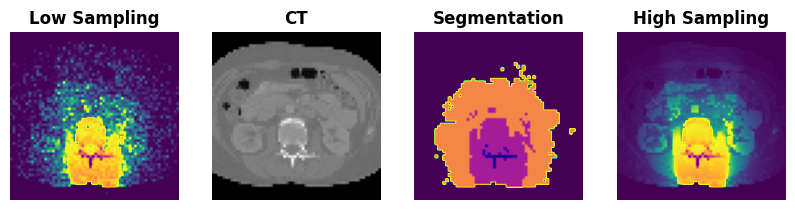

In [12]:
train_lenght = int(0.70*len(LS_dataset))
val_lenght = int(0.80*len(LS_dataset))

LS = LS_dataset[val_lenght,:,:]
CT = CT_dataset[val_lenght,:,:]
Seg = Seg_dataset[val_lenght,:,:]
HS = y_dataset[val_lenght,:,:]

fig, axes = plt.subplots(1, 4, figsize=(10, 5))

axes[0].imshow(LS, interpolation=None, cmap=newcmp)
axes[0].set_title('Low Sampling', fontweight='bold')
axes[0].axis('off')

axes[1].imshow(CT, interpolation=None, cmap='gray')
axes[1].set_title('CT', fontweight='bold')
axes[1].axis('off')

axes[2].imshow(Seg, interpolation=None, cmap=newcmp)
axes[2].set_title('Segmentation', fontweight='bold')
axes[2].axis('off')

axes[3].imshow(HS, interpolation=None, cmap=newcmp)
axes[3].set_title('High Sampling', fontweight='bold')
axes[3].axis('off')

plt.show()

# UNet Model with PyTorch

In [13]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        
        # Output
        self.output_conv = nn.Conv2d(64, 1, kernel_size=1, padding=0)
    
    def conv_block(self, in_channels, out_channels):
        """Bloc de convolution : Conv2D -> ReLU -> Conv2D -> ReLU."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        c1 = self.enc1(x)
        p1 = F.max_pool2d(c1, kernel_size=2, stride=2)
        
        c2 = self.enc2(p1)
        p2 = F.max_pool2d(c2, kernel_size=2, stride=2)
        
        c3 = self.enc3(p2)
        p3 = F.max_pool2d(c3, kernel_size=2, stride=2)
        
        c4 = self.enc4(p3)
        p4 = F.max_pool2d(c4, kernel_size=2, stride=2)
        
        # Bottleneck
        bn = self.bottleneck(p4)
        
        # Decoder
        u4 = self.upconv4(bn)
        u4 = torch.cat((u4, c4), dim=1)  # Skip connection
        c5 = self.dec4(u4)
        
        u3 = self.upconv3(c5)
        u3 = torch.cat((u3, c3), dim=1)  # Skip connection
        c6 = self.dec3(u3)
        
        u2 = self.upconv2(c6)
        u2 = torch.cat((u2, c2), dim=1)  # Skip connection
        c7 = self.dec2(u2)
        
        u1 = self.upconv1(c7)
        u1 = torch.cat((u1, c1), dim=1)  # Skip connection
        c8 = self.dec1(u1)
        
        # Output
        outputs = self.output_conv(c8)
        return outputs

In [19]:
unettest = UNet()
batch_size = 5
#summary(unettest, input_size=(3, 64, 64), batch_size=batch_size)
type(LS_dataset), type(Seg_dataset)

(numpy.ndarray, numpy.ndarray)

In [20]:
train_lenght = int(0.70*len(LS_dataset))
val_lenght = int(0.80*len(LS_dataset))

LS_train = torch.tensor(LS_dataset[:train_lenght,:,:], dtype=torch.float32).unsqueeze(1)
CT_train = torch.tensor(CT_dataset[:train_lenght,:,:], dtype=torch.float32).unsqueeze(1)
Seg_train = torch.tensor(Seg_dataset[:train_lenght,:,:], dtype=torch.float32).unsqueeze(1)
x_train = torch.cat((LS_train, CT_train, Seg_train), dim=1)
y_train = torch.tensor(y_dataset[:train_lenght,:,:], dtype=torch.float32).unsqueeze(1)

LS_val = torch.tensor(LS_dataset[train_lenght:val_lenght,:,:], dtype=torch.float32).unsqueeze(1)
CT_val = torch.tensor(CT_dataset[train_lenght:val_lenght,:,:], dtype=torch.float32).unsqueeze(1)
Seg_val = torch.tensor(Seg_dataset[train_lenght:val_lenght,:,:], dtype=torch.float32).unsqueeze(1)
x_val = torch.cat((LS_val, CT_val, Seg_val), dim=1)
y_val = torch.tensor(y_dataset[train_lenght:val_lenght,:,:],  dtype=torch.float32).unsqueeze(1)

LS_test = torch.tensor(LS_dataset[val_lenght:,:,:], dtype=torch.float32).unsqueeze(1)
CT_test = torch.tensor(CT_dataset[val_lenght:,:,:], dtype=torch.float32).unsqueeze(1)
Seg_test = torch.tensor(Seg_dataset[val_lenght:,:,:], dtype=torch.float32).unsqueeze(1)
x_test = torch.cat((LS_test, CT_test, Seg_test), dim=1)
y_test = torch.tensor(y_dataset[val_lenght:,:,:], dtype=torch.float32).unsqueeze(1)

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

(torch.Size([69, 3, 64, 64]),
 torch.Size([69, 1, 64, 64]),
 torch.Size([10, 3, 64, 64]),
 torch.Size([10, 1, 64, 64]),
 torch.Size([20, 3, 64, 64]),
 torch.Size([20, 1, 64, 64]))

In [21]:
batch_size = 10

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [22]:
def evaluate_model(model, val_loader, criterion, device):
    model.eval()  # Met le modèle en mode évaluation (désactive le dropout, etc.)
    val_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():  # Pas besoin de calculer les gradients pendant l'évaluation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Passage dans le modèle
            outputs = model(inputs)
            
            # Calcul de la perte
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            # Collecter les prédictions et les vraies étiquettes
            preds = outputs.argmax(dim=1)  # Utilisez `argmax` si c'est une tâche de classification multi-classe
            all_preds.extend(preds.cpu().numpy())  # Déplacer les prédictions vers le CPU et les collecter
            all_targets.extend(targets.cpu().numpy())  # Idem pour les cibles
            
    # Calcul de la perte moyenne de validation
    val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

criterion = nn.L1Loss()  # Loss pour le débruitage
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)  # Déplacer vers GPU si disponible

        # Initialiser les gradients
        optimizer.zero_grad()

        # Passer les données dans le modèle
        outputs = model(inputs)

        # Calculer la perte
        loss = criterion(outputs, targets)

        # Rétropropagation
        loss.backward()

        # Mise à jour des poids
        optimizer.step()

        # Accumuler la perte
        running_loss += loss.item()

        # Afficher la perte
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss:.4f}")
    
    # Évaluation sur le jeu de validation
    evaluate_model(model, val_loader, criterion, device)

    # Vous pouvez ajouter des fonctions d'évaluation ici (sur un jeu de validation, par exemple)

torch.save(model.state_dict(), r"ApplicationsUNet\UNet LS+CT-HS\models\UNet.pth")
print("Entraînement terminé")

Epoch [1/200], Batch [1/7], Loss: 0.1050
Epoch [1/200], Batch [2/7], Loss: 0.0984
Epoch [1/200], Batch [3/7], Loss: 0.0930
Epoch [1/200], Batch [4/7], Loss: 0.0892
Epoch [1/200], Batch [5/7], Loss: 0.0804
Epoch [1/200], Batch [6/7], Loss: 0.0751
Epoch [1/200], Batch [7/7], Loss: 0.0676
Validation Loss: 0.0608
Epoch [2/200], Batch [1/7], Loss: 0.0576
Epoch [2/200], Batch [2/7], Loss: 0.0501
Epoch [2/200], Batch [3/7], Loss: 0.0378
Epoch [2/200], Batch [4/7], Loss: 0.0280
Epoch [2/200], Batch [5/7], Loss: 0.0204
Epoch [2/200], Batch [6/7], Loss: 0.0264
Epoch [2/200], Batch [7/7], Loss: 0.0311
Validation Loss: 0.0315
Epoch [3/200], Batch [1/7], Loss: 0.0337
Epoch [3/200], Batch [2/7], Loss: 0.0321
Epoch [3/200], Batch [3/7], Loss: 0.0301
Epoch [3/200], Batch [4/7], Loss: 0.0262
Epoch [3/200], Batch [5/7], Loss: 0.0230
Epoch [3/200], Batch [6/7], Loss: 0.0200
Epoch [3/200], Batch [7/7], Loss: 0.0188
Validation Loss: 0.0214
Epoch [4/200], Batch [1/7], Loss: 0.0194
Epoch [4/200], Batch [2/7]

KeyboardInterrupt: 

In [ ]:
def calculate_psnr(original, reconstructed, data_range=1.0):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return np.inf
    psnr = 10*np.log10(data_range**2 / mse)
    return psnr

Mean PSNR: 43.55 dB


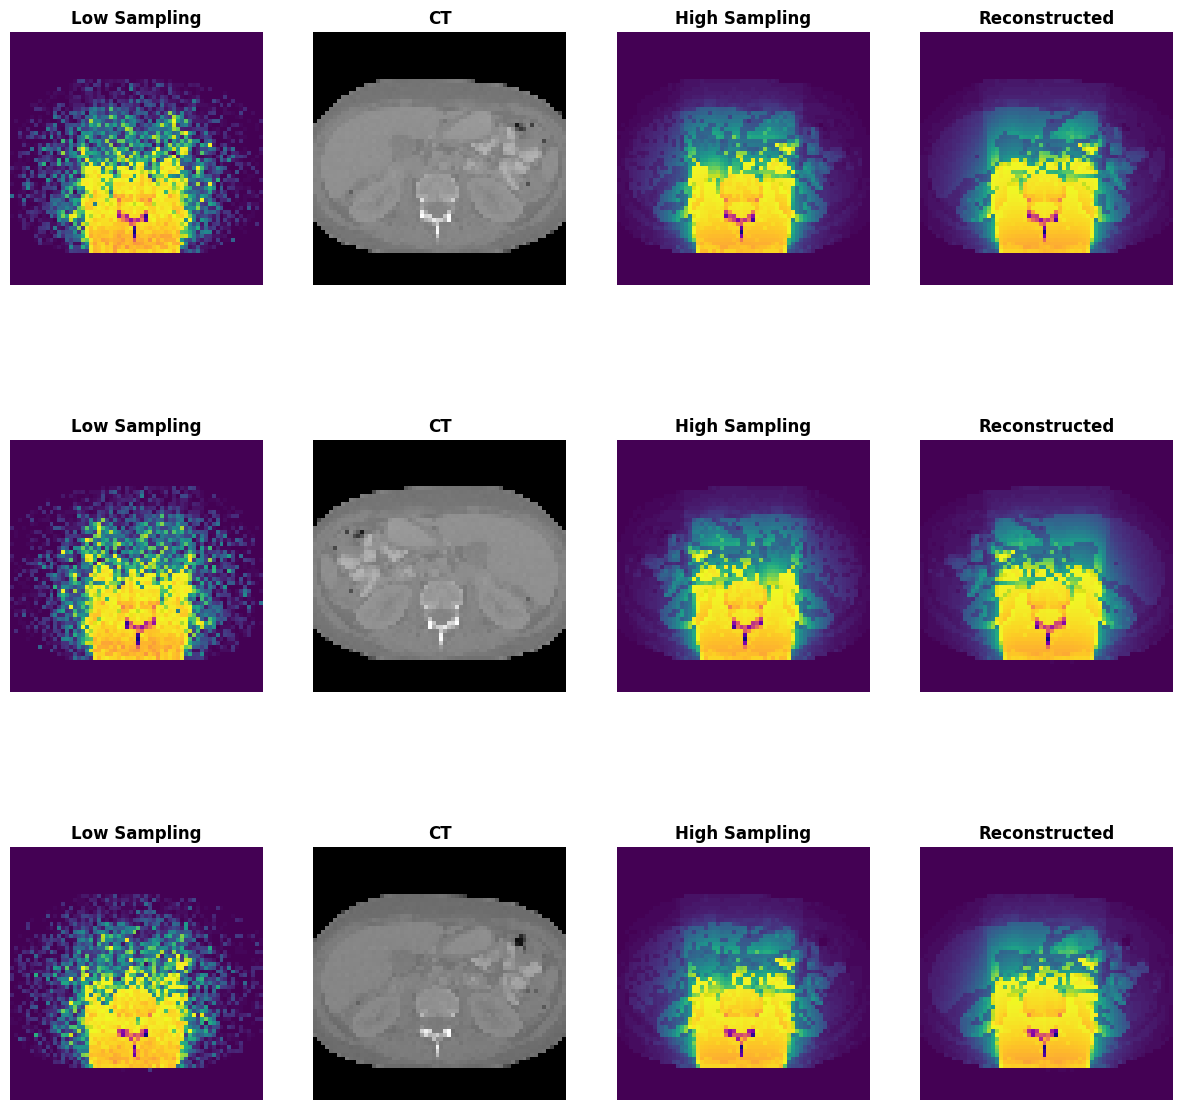

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Déplacez le modèle sur l'appareil approprié
model = model.to(device)

# Déplacez les données d'entrée sur le même appareil que le modèle
x_test = x_test.to(device)

# Effectuez la prédiction
model.eval()
with torch.no_grad():
    y_pred = model(x_test).cpu()  # Revenir sur CPU si nécessaire pour l'évaluation

y_pred2 = y_pred.cpu().squeeze(1).numpy()
y_test2 = y_test.cpu().squeeze(1).numpy()

fig, axes = plt.subplots(3, 4, figsize=(15, 15))

for i in range(3):
    axes[i, 0].imshow(x_test[i, 0].cpu().numpy(), cmap=newcmp)
    axes[i, 0].set_title('Low Sampling', fontweight='bold')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(x_test[i, 1].cpu().numpy(), cmap='gray')
    axes[i, 1].set_title('CT', fontweight='bold')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(y_test2[i], cmap=newcmp)
    axes[i, 2].set_title('High Sampling', fontweight='bold')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(y_pred2[i], cmap=newcmp)
    axes[i, 3].set_title('Reconstructed', fontweight='bold')
    axes[i, 3].axis('off')

mean_psnr = np.mean([calculate_psnr(y_test2[i], y_pred2[i]) for i in range(len(y_test2))])
print(f"Mean PSNR: {mean_psnr:.2f} dB")